In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

### Scripts

In [ ]:
def analyze_clusters(df, group_n):
    """
    Analyzes clusters in a DataFrame and prints cluster statistics, including a distance matrix and summary table.

    Args:
        df (pd.DataFrame): DataFrame with latitude, longitude, and cluster assignments.
        group_n (float): Hyperparameter specifying the cluster column (e.g., 0.5, 1.0).
    """

    group_col = f"group_{group_n}"

    if group_col not in df.columns:
        print(f"Error: Column '{group_col}' not found in DataFrame.")
        return

    unique_groups = sorted(df[group_col].unique())
    num_groups = len(unique_groups)

    print(f"Total number of groups (clusters): {num_groups}")

    group_data = {}
    summary_data = []
    for group in unique_groups:
        group_df = df[df[group_col] == group]
        num_elements = len(group_df)
        group_data[group] = {
            "num_elements": num_elements,
            "coordinates": group_df[["latitude", "longitude"]].values,
        }
        summary_data.append({"Group": group, "Total Elements": num_elements, "Mean Distance": None}) #initialize the table.

    # Calculate mean distance within each group
    for i, (group, data) in enumerate(group_data.items()):
        if data["num_elements"] > 1:
            distances = cdist(data["coordinates"], data["coordinates"])
            mean_distance = np.mean(distances[np.triu_indices(len(distances), k=1)])
            summary_data[i]["Mean Distance"] = f"{mean_distance:.4f}"
        else:
            summary_data[i]["Mean Distance"] = "N/A"

    # Create summary table DataFrame and print it
    summary_df = pd.DataFrame(summary_data).set_index('Group')
    
    # Calculate distance between cluster centroids and create a matrix
    centroids = {}
    for group, data in group_data.items():

    distance_matrix = np.zeros((num_groups, num_groups))
    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            dist = np.linalg.norm(centroids[group1] - centroids[group2])
            distance_matrix[i, j] = dist

    # Create DataFrame for better visualization
    distance_df = pd.DataFrame(distance_matrix, index=unique_groups, columns=unique_groups)
    return summary_df, distance_df

# Data

## Importing data

In [2]:
files = ["geotagged_images_0.5km.csv", "geotagged_images_1.0km.csv", "geotagged_images_1.5km.csv", "geotagged_images_2.0km.csv"]

In [3]:
imported_data = []
for file in files:
    data_dict = {
        'name': file,
        'data': pd.read_csv(file)
    }
    imported_data.append(data_dict)

## Creating dataframe

In [4]:
df = imported_data[0]['data'].copy()

# Merge data of lot groups by distance (0.5 / 1 / 1.5 / 2 meters)
df = df.merge(imported_data[1]['data'], on=['filename','latitude','longitude'], suffixes=('', '_1.0'))
df = df.merge(imported_data[2]['data'], on=['filename','latitude','longitude'], suffixes=('', '_1.5'))
df = df.merge(imported_data[3]['data'], on=['filename','latitude','longitude'], suffixes=('', '_2.0'))
df.rename(columns={"group": "group_0.5"}, inplace=True)

In [5]:
df

,filename,latitude,longitude,group_0.5,group_1.0,group_1.5,group_2.0
0,DJI_0287.JPG,-52.427767,-89.1871,1,1,1,1
1,DJI_0290.JPG,-52.428567,-89.1876,1,1,1,1
2,DJI_0288.JPG,-52.426167,-89.1837,1,1,1,1
3,DJI_0289.JPG,-52.430867,-89.1869,1,1,1,1
4,DJI_0293.JPG,-46.199667,-87.8559,2,2,2,2
...,...,...,...,...,...,...,...
58,DJI_0303.JPG,-85.650300,-99.8866,22,14,13,13
59,DJI_0302.JPG,-85.654800,-99.8871,23,14,13,13
60,DJI_0301.JPG,-85.657000,-99.8865,23,14,13,13
61,DJI_0328.JPG,-52.277667,-84.6529,24,3,3,3


In [6]:
df.to_csv('geotagged_merged_data.csv', index=False)

# Defining groups

In [7]:
df = df.sort_values(by='group_0.5')
df

,filename,latitude,longitude,group_0.5,group_1.0,group_1.5,group_2.0
0,DJI_0287.JPG,-52.427767,-89.1871,1,1,1,1
1,DJI_0290.JPG,-52.428567,-89.1876,1,1,1,1
2,DJI_0288.JPG,-52.426167,-89.1837,1,1,1,1
3,DJI_0289.JPG,-52.430867,-89.1869,1,1,1,1
4,DJI_0293.JPG,-46.199667,-87.8559,2,2,2,2
...,...,...,...,...,...,...,...
58,DJI_0303.JPG,-85.650300,-99.8866,22,14,13,13
59,DJI_0302.JPG,-85.654800,-99.8871,23,14,13,13
60,DJI_0301.JPG,-85.657000,-99.8865,23,14,13,13
61,DJI_0328.JPG,-52.277667,-84.6529,24,3,3,3


### Visualization

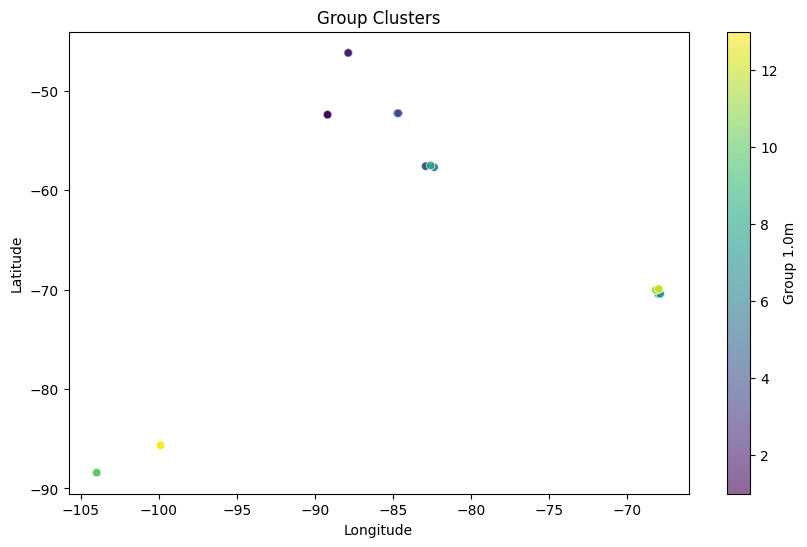

In [9]:
import matplotlib.pyplot as plt

# Plotting the group clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['group_2.0'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Group 1.0m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Group Clusters')
plt.show()

As we can see, there are 3 larger groups and, at least, 7 smaller clusters (depending on the distanced used as threshold).

So, let's identify them properly.

# Clusters analysis

#### 2km clusters

In [46]:
summary_2, distance_2 = analyze_clusters(df, 2.0)
print("\nMean distance between elements within each group:")
summary_2

Total number of groups (clusters): 13

Mean distance between elements within each group:


,Total Elements,Mean Distance
Group,,
1,5,0.0045
2,8,0.0110
3,8,0.0065
4,4,0.0049
5,2,0.0036
6,1,N/A
7,4,0.0089
8,2,0.0090
9,5,0.0062


_N/A = Groups of only 1 element, no mean distance._

In [45]:
# Show distance between cluster centroids
print("Distance between cluster centroids (Distance Matrix):")
distance_2

Distance between cluster centroids (Distance Matrix):


,1,2,3,4,5,6,7,8,9,10,11,12,13
1,0.000000,6.365407,4.529917,8.139464,8.640974,4.448210,27.901803,8.347088,27.822745,38.906452,27.445344,27.525493,34.907123
2,6.365407,0.000000,6.867496,12.426012,12.757490,6.828121,31.406650,12.493299,31.345287,45.184384,30.936824,30.980416,41.245252
3,4.529917,6.867496,0.000000,5.600344,5.900627,0.081835,24.723728,5.643367,24.656573,40.970723,24.256480,24.312068,36.682332
4,8.139464,12.426012,5.600344,0.000000,0.562975,5.628354,19.763294,0.330092,19.684788,37.330792,19.306319,19.386045,32.795996
5,8.640974,12.757490,5.900627,0.562975,0.000000,5.934862,19.272608,0.293935,19.195424,37.552761,18.814063,18.891038,32.989597
6,4.448210,6.828121,0.081835,5.628354,5.934862,0.000000,24.780745,5.675788,24.713351,40.933899,24.313638,24.369709,36.650178
7,27.901803,31.406650,24.723728,19.763294,19.272608,24.780745,0.000000,19.566252,0.121187,40.331676,0.470875,0.488050,35.449521
8,8.347088,12.493299,5.643367,0.330092,0.293935,5.675788,19.566252,0.000000,19.489001,37.572240,19.107775,19.184852,33.024767
9,27.822745,31.345287,24.656573,19.684788,19.195424,24.713351,0.121187,19.489001,0.000000,40.216103,0.430226,0.499611,35.333301
10,38.906452,45.184384,40.970723,37.330792,37.552761,40.933899,40.331676,37.572240,40.216103,0.000000,40.258761,40.468090,4.931037


_***NOTE:*** distances are expressed nor in meters or kilometers because ***they are euclidean distances***._

#### 1km clusters

In [48]:
summary_1, distance_1 = analyze_clusters(df, 1.0)
print("\nMean distance between elements within each group:")
summary_1

Total number of groups (clusters): 15

Mean distance between elements within each group:


,Total Elements,Mean Distance
Group,,
1,5,0.0045
2,6,0.0073
3,8,0.0065
4,4,0.0049
5,2,0.0036
6,1,N/A
7,4,0.0089
8,2,0.0090
9,5,0.0062


_N/A = Groups of only 1 element, no mean distance._

In [49]:
# Show distance between cluster centroids
print("Distance between cluster centroids (Distance Matrix):")
distance_1

Distance between cluster centroids (Distance Matrix):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,0.000000,6.369006,4.529917,8.139464,8.640974,4.448210,27.901803,8.347088,27.822745,38.906452,6.354613,27.445344,27.525493,34.905322,34.917931
2,6.369006,0.000000,6.869183,12.427960,12.759312,6.829846,31.407566,12.495157,31.346216,45.188199,0.015894,30.937736,30.981303,41.247177,41.259802
3,4.529917,6.869183,0.000000,5.600344,5.900627,0.081835,24.723728,5.643367,24.656573,40.970723,6.862446,24.256480,24.312068,36.680562,36.692953
4,8.139464,12.427960,5.600344,0.000000,0.562975,5.628354,19.763294,0.330092,19.684788,37.330792,12.420174,19.306319,19.386045,32.794281,32.806287
5,8.640974,12.759312,5.900627,0.562975,0.000000,5.934862,19.272608,0.293935,19.195424,37.552761,12.752031,18.814063,18.891038,32.987891,32.999831
6,4.448210,6.829846,0.081835,5.628354,5.934862,0.000000,24.780745,5.675788,24.713351,40.933899,6.822958,24.313638,24.369709,36.648407,36.660803
7,27.901803,31.407566,24.723728,19.763294,19.272608,24.780745,0.000000,19.566252,0.121187,40.331676,31.403904,0.470875,0.488050,35.448405,35.456223
8,8.347088,12.495157,5.643367,0.330092,0.293935,5.675788,19.566252,0.000000,19.489001,37.572240,12.487732,19.107775,19.184852,33.023056,33.035033
9,27.822745,31.346216,24.656573,19.684788,19.195424,24.713351,0.121187,19.489001,0.000000,40.216103,31.342503,0.430226,0.499611,35.332183,35.340011
10,38.906452,45.188199,40.970723,37.330792,37.552761,40.933899,40.331676,37.572240,40.216103,0.000000,45.172941,40.258761,40.468090,4.932354,4.923139


_***NOTE:*** distances are expressed nor in meters or kilometers because ***they are euclidean distances***._

#### .5km clusters

In [50]:
summary_05, distance_05 = analyze_clusters(df, 0.5)
print("\nMean distance between elements within each group:")
summary_1

Total number of groups (clusters): 25

Mean distance between elements within each group:


,Total Elements,Mean Distance
Group,,
1,5,0.0045
2,6,0.0073
3,8,0.0065
4,4,0.0049
5,2,0.0036
6,1,N/A
7,4,0.0089
8,2,0.0090
9,5,0.0062


_N/A = Groups of only 1 element, no mean distance._

In [51]:
# Show distance between cluster centroids
print("Distance between cluster centroids (Distance Matrix):")
distance_05

Distance between cluster centroids (Distance Matrix):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
1,0.000000,6.370479,4.532042,4.525943,8.138935,8.640477,4.525859,4.448513,6.375062,0.005925,27.902625,6.365035,8.347724,27.822199,38.907633,27.899897,8.345463,6.355798,27.444806,27.524962,38.903403,34.902196,34.908033,4.535928,34.916750
2,6.370479,0.000000,6.871777,6.873937,12.429866,12.761295,6.869216,6.831885,0.008023,6.364555,31.410402,0.005812,12.496125,31.348642,45.190430,31.409593,12.498113,0.015183,30.940169,30.983746,45.186133,41.245281,41.251098,6.870482,41.259845
3,4.532042,6.871777,0.000000,0.008118,5.600108,5.900240,0.006185,0.083639,6.871082,4.530534,24.723465,6.866293,5.641777,24.655606,40.974073,24.722045,5.644276,6.862982,24.255503,24.311077,40.970136,36.679652,36.685595,0.005114,36.694024
4,4.525943,6.873937,0.008118,0.000000,5.596700,5.897454,0.005206,0.078024,6.873251,4.524441,24.723416,6.868450,5.638810,24.655523,40.966386,24.721992,5.641297,6.865128,24.255472,24.311114,40.962448,36.672143,36.678086,0.013232,36.686515
5,8.138935,12.429866,5.600108,5.596700,0.000000,0.562975,5.601715,5.628354,12.429763,8.141582,19.764631,12.424254,0.334158,19.684788,37.332779,19.761958,0.326038,12.420174,19.306319,19.386045,37.329202,32.792292,32.798259,5.602202,32.806287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,38.903403,45.186133,40.970136,40.962448,37.329202,37.551193,40.966916,40.932147,45.191669,38.909248,40.336402,45.181065,37.574942,40.215473,0.005013,40.325694,37.566378,45.171031,40.258108,40.467437,0.000000,4.933238,4.927876,40.974958,4.922239
22,34.902196,41.245281,36.679652,36.672143,32.792292,32.985903,36.676770,36.646426,41.250405,34.908099,35.452107,41.240029,33.025269,35.330546,4.935274,35.441430,33.016864,41.230322,35.365672,35.574934,4.933238,0.000000,0.005969,36.684358,0.014572
23,34.908033,41.251098,36.685595,36.678086,32.798259,32.991867,36.682713,36.652368,41.256222,34.913937,35.457016,41.245846,33.031236,35.335458,4.929909,35.446339,33.022831,41.236140,35.370625,35.579888,4.927876,0.005969,0.000000,36.690301,0.008936
24,4.535928,6.870482,0.005114,0.013232,5.602202,5.901941,0.010651,0.087421,6.869781,4.534416,24.723434,6.864999,5.643593,24.655597,40.978895,24.722016,5.646099,6.861696,24.255461,24.310993,40.974958,36.684358,36.690301,0.000000,36.698730


_***NOTE:*** distances are expressed nor in meters or kilometers because ***they are euclidean distances***._